## Module 1: Vanilla GAN

In [105]:
# Initialization of libraries
import torch
import torch.nn
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import random
from sklearn.mixture import GMM
device = torch.device('cuda')
%matplotlib inline

In [106]:
# defining parameters for the training
mb_size = 128 # Batch Size
Z_dim = 64  # Length of noise vector
X_dim = 1  # Input Length
h_dim = 128  # Hidden Dimension
lr = 1e-4    # Learning Rate

Custom weights initialization function.

(Read later about Xavier initialization: http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization)

(Link to paper: https://arxiv.org/abs/1406.2661)

We are using MNIST dataset for these experiments. Let us load the dataset. We will also define some functions that will be used for the other modules of this lab. Note that we are flattening the MNIST images into one dimensional vectors.

/home/shyam.nandan/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)


[[ 61.25953069]
 [ 80.53909592]
 [ 11.96357701]
 [ 21.04461267]
 [ 10.55752614]
 [ 13.06812035]
 [ 13.29382082]
 [ 19.77366113]
 [ 22.31354885]
 [ 60.25797928]]
0.0


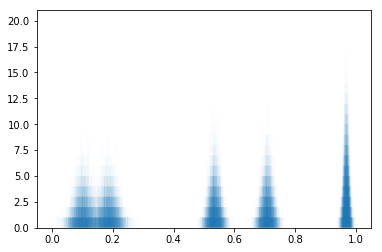

In [131]:
def gaussian(x):
    f1 = np.exp(-np.power(x - 10, 2.) / (2 * np.power(3, 2.)))
    f2 = np.exp(-np.power(x - 20, 2.) / (2 * np.power(3, 2.)))
    f3 = np.exp(-np.power(x - 60, 2.) / (2 * np.power(2, 2.)))
    f4 = np.exp(-np.power(x - 80, 2.) / (2 * np.power(2, 2.)))
    f5 = np.exp(-np.power(x - 110, 2.) / (2 * np.power(1, 2.)))
    return (f1+f2+f3+f4)

#x_values = np.linspace(0, 120, 200000)
#data = gaussian(x_values)
#data = data/max(data)
#plt.plot(data)
np.random.seed(1)
gmm = GMM(5)
gmm.means_ = np.array([[10], [20], [60], [80], [110]])
gmm.covars_ = np.array([[3], [3], [2], [2], [1]]) ** 2
gmm.weights_ = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

X = gmm.sample(200000)
print(X[0:10])
data = X
data = (data - X.min())/(X.max()-X.min())
plt.hist(data, 200000, normed=False, histtype='stepfilled', alpha=1)
print(data.min())

 Now, let us define the network structure. For this experiment, we are not using deep networks. We are not even using torch.nn layers. Instead, we will use simple linear fully connected layers. The generator and discriminators are 2-layer networks. This is why we flattened the images in the block above.

In [132]:
G = torch.nn.Sequential(
    torch.nn.Linear(Z_dim, h_dim),
    torch.nn.PReLU(),
    torch.nn.Linear(h_dim, h_dim),
    torch.nn.PReLU(),
    torch.nn.Linear(h_dim, X_dim),
    torch.nn.Sigmoid()
)

D = torch.nn.Sequential(
    torch.nn.Linear(X_dim, h_dim),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(h_dim, h_dim),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(h_dim, 1),
    torch.nn.Sigmoid()
)

G = G.cuda()
D = D.cuda()

Here, we will gather the parameters of the generator and the discriminator so that they can be given to the Adam optimizer to update the weights

In [133]:
G_solver = optim.Adam(G.parameters(), lr)
D_solver = optim.Adam(D.parameters(), lr)

ones_label = torch.ones(mb_size,1)
zeros_label = torch.zeros(mb_size,1)
loss = nn.BCELoss()
ones_label = ones_label.to(device)
zeros_label = zeros_label.to(device)

In [134]:
# Reset the gradients to zero
params = [G, D]
def reset_grad():
    for net in params:
        net.zero_grad()

 Now, we will start the actual training. The training alternates between updating the discriminator network's weights and updating the generator's weight.First, we update the discriminator's weight. We take a minibatch from the dataset and do a forward pass on the discriminator with the label '1'. Then, we feed noise into the generator and feed the generated images into the discriminator with the label '0'. We backpropagate the error and update the discriminator weights. To update the generator weights, we feed noise to the generator and feed the generated images into the discriminator with the label '1'. This error is backpropagated to update the weights of G.

In [135]:
data_index = 0
for it in range(198000):
    
    
    # ###
    if ((data_index + 1)*mb_size>len(data)):
        data_index = 0
    # ###
    #z = torch.randn(mb_size, Z_dim)
    z = torch.FloatTensor(mb_size, Z_dim).uniform_(-1, 1)
    X = torch.from_numpy(np.array(data[data_index*mb_size : (data_index + 1)*mb_size]))
    X = X.view(mb_size, 1)
    X = X.type(torch.FloatTensor)
    X = X.to(device)
    z = z.to(device)
    
    # Dicriminator forward-loss-backward-update
    #forward pass
    G_sample = G(z)
    D_real = D(X)
    D_fake = D(G_sample)
    
    # Calculate the loss
    D_loss_real = loss(D_real, ones_label)
    D_loss_fake = loss(D_fake, zeros_label)
    D_loss = D_loss_real + D_loss_fake

    # Calulate and update gradients of discriminator
    D_loss.backward()
    D_solver.step()

    # reset gradient
    reset_grad()

    # Generator forward-loss-backward-update
    
    #z = torch.randn(mb_size, Z_dim)
    z = torch.FloatTensor(mb_size, Z_dim).uniform_(-1, 1)
    z = z.to(device)
    G_sample = G(z)
    D_fake = D(G_sample)

    G_loss = loss(D_fake, ones_label)

    G_loss.backward()
    G_solver.step()

    # reset gradient
    reset_grad()
    data_index = data_index + 1
    # Print and plot every now and then
    if it % 10000 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(it, D_loss.data.cpu().numpy(), G_loss.data.cpu().numpy()))

Iter-0; D_loss: 1.38275837898; G_loss: 0.693978488445
Iter-10000; D_loss: 1.32821035385; G_loss: 0.761459052563
Iter-20000; D_loss: 1.37750244141; G_loss: 0.760051012039
Iter-30000; D_loss: 1.3864556551; G_loss: 0.735770404339
Iter-40000; D_loss: 1.37976050377; G_loss: 0.707929611206
Iter-50000; D_loss: 1.3865904808; G_loss: 0.709010481834
Iter-60000; D_loss: 1.38838100433; G_loss: 0.697671771049
Iter-70000; D_loss: 1.33779454231; G_loss: 0.756409287453
Iter-80000; D_loss: 1.41952466965; G_loss: 0.704879105091
Iter-90000; D_loss: 1.38234674931; G_loss: 0.720855236053
Iter-100000; D_loss: 1.38029098511; G_loss: 0.709856033325
Iter-110000; D_loss: 1.38914251328; G_loss: 0.678947985172
Iter-120000; D_loss: 1.37909913063; G_loss: 0.703401207924
Iter-130000; D_loss: 1.38190758228; G_loss: 0.697667479515
Iter-140000; D_loss: 1.37582969666; G_loss: 0.689107298851
Iter-150000; D_loss: 1.38695311546; G_loss: 0.697121620178
Iter-160000; D_loss: 1.38445770741; G_loss: 0.682939887047
Iter-170000; 

 Let us see the images generated by the generator:

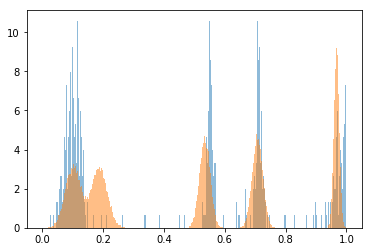

In [153]:
import numpy as np
final = np.zeros(1500*mb_size, dtype = float)
for i in range(1500):
    z = torch.FloatTensor(64, Z_dim).uniform_(-1, 1)
    z = z.to(device)
    l = G(z).cpu().detach().numpy()
    final[i*mb_size : ((i+ 1)*mb_size -1)] = l[0]
p1 = plt.hist(final, 1000, normed=True, histtype='bar', alpha=0.5)
p2 = plt.hist(data, 1000, normed=True, histtype='bar', alpha=0.5)

In [42]:
l = G(z).cpu().detach().numpy()
print(len(l))

64


In [43]:
flat_list = [item for sublist in l for item in sublist]
print(flat_list[0])


0.0431691


### Image interpolation

Let us try to interpolate between images

## Points to ponder
1. What happens if we don't do Xavier initialization?
2. What happens if we change the learning rate and other parameters?
3. What happens if we reduce the size of hidden layer to 10?
4. Is there any way to determine the class of the generated images by changing the input noise vector?
5. How long do we have to train the GAN to get good results? Can you plot the loss of the generator and discriminator and see if there is a correlation?
